# Reinforcement Learning
Reinforcement learning is a machine learning training method based on rewarding desired behaviors and/or punishing undesired ones.

In general, a reinforcement learning agent is able to perceive and interpret its environment, take actions and learn through trial and error.

<img src="https://raw.githubusercontent.com/MandM-DataScience/chess-engine/master/images/Reinforcement_learning_diagram.svg.png" alt="Reinforcement learning diagram" width=300 height=300>

The agent takes in a representation of the environment (State) and decides which Action to take (based on what it thinks the reward will be).

At the beginning it has no idea of which Action will yield the best reward, so it will take random Actions and discover step by step which Action is the best for each State!

This is the trial and error part of the process.

So, the main components of our reinforcement learning model are:
- State representation (how are we going to encode a chess board position into a State)
- Action space (what possible Action can the agent make)
- Neural network architecture (how the Agent chooses which Action to take based on the current State)
- Reward signal (how are we going to reward/punish the agent for an Action it took)
- Exploration strategy (how do we balance the exploration of new Actions with the exploitation of what the Agent has learned in previous steps)

## State Representation

A chess board position can be efficiently stored as a list of bitboards.

A bitboard is a specialized bit array data structure commonly used in computer systems that play board games, where each bit corresponds to a game board space or piece.

To represent the whole board position using bitboards we need one bitboard for each piece type + one bitboard for the empty squares.

Let's see an example with the starting board.

In [1]:
import chess
board = chess.Board()
print(board.unicode())

♜ ♞ ♝ ♛ ♚ ♝ ♞ ♜

♟ ♟ ♟ ♟ ♟ ♟ ♟ ♟

⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘

⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘

⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘

⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘

♙ ♙ ♙ ♙ ♙ ♙ ♙ ♙

♖ ♘ ♗ ♕ ♔ ♗ ♘ ♖


In [2]:
def print_bitboard(bitboard):
    
    # for each row
    for i in range(8):
        
        # print bitboard of 1s/0s (we have to mirror the bitboard)
        if i == 0:
            print(format(bitboard, "064b")[8*(i+1)-1::-1])
        else:
            print(format(bitboard, "064b")[8*(i+1)-1:8*i-1:-1])

# bitboard of pawns
print_bitboard(board.pawns)

00000000

11111111

00000000

00000000

00000000

00000000

11111111

00000000


In [3]:
# bitboard of kings
print_bitboard(board.kings)

00001000

00000000

00000000

00000000

00000000

00000000

00000000

00001000


In [4]:
# bitboard of bishops
print_bitboard(board.bishops)

00100100

00000000

00000000

00000000

00000000

00000000

00000000

00100100


In [5]:
# bitboard of empty squares
print_bitboard(board.occupied ^ 2 ** 64 -1)

00000000

00000000

11111111

11111111

11111111

11111111

00000000

00000000


## Action Space
The Action space must contain all POSSIBLE moves, not VALID moves.

We decided the number of possible moves as 4096 (64 squares from -> 64 squares to).

Out of this 4096 combinations, not all of them are truly possible (for example no piece can move from square a1 to square b7). But for this exercise we decide to ignore this as it would complicate things.

Out of this set of possible moves, of course only a very small subset of moves can be chosen in a specific state.

To narrow down these valid moves we are going to apply a masking layer in our Neural Net.

In [6]:
import numpy as np

def encode_valid_moves(board):
    
    valid_moves_dict = {}
    
    # for each valid move
    for move in board.legal_moves:
        
        # compute index based on starting square and target square
        index = 64 * (move.from_square) + (move.to_square)
        valid_moves_dict[index] = move
    
    return valid_moves_dict

valid_moves_dict = encode_valid_moves(board)
valid_moves_dict

{407: Move.from_uci('g1h3'),
 405: Move.from_uci('g1f3'),
 82: Move.from_uci('b1c3'),
 80: Move.from_uci('b1a3'),
 983: Move.from_uci('h2h3'),
 918: Move.from_uci('g2g3'),
 853: Move.from_uci('f2f3'),
 788: Move.from_uci('e2e3'),
 723: Move.from_uci('d2d3'),
 658: Move.from_uci('c2c3'),
 593: Move.from_uci('b2b3'),
 528: Move.from_uci('a2a3'),
 991: Move.from_uci('h2h4'),
 926: Move.from_uci('g2g4'),
 861: Move.from_uci('f2f4'),
 796: Move.from_uci('e2e4'),
 731: Move.from_uci('d2d4'),
 666: Move.from_uci('c2c4'),
 601: Move.from_uci('b2b4'),
 536: Move.from_uci('a2a4')}

Each one of the 4096 moves represent a move from a square to another. The first move (which is not actually possible) is move from a1 to a1. The second a1 -> b1, the third a1 -> c1, and so on.

The index grows for the target square from left to right (by 1) and from bottom to top (by 8).

The index grows for the starting square from left to right (by 64) and from bottom to top (by 512).

With these moves encoded in this way we can build a mask (of 0s/1s) in order to disable the output layer nodes that correspond to a non-valid move.

In [7]:
def mask_and_valid_moves(board):

    mask = np.zeros((64, 64))
    valid_moves_dict = {}
    
    # for each valid move
    for move in board.legal_moves:
        
        # mask is a matrix
        mask[move.from_square, move.to_square] = 1
        
        # compute index based on starting square and target square
        index = 64 * (move.from_square) + (move.to_square)
        
        valid_moves_dict[index] = move
    
    return mask, valid_moves_dict

mask, valid_moves_dict = mask_and_valid_moves(board)
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Neural Network architecture
We are going to use an hybrid neural network consisting of an initial series of convolutional layers and a following series of fully connected layers.

The convolutional layers are used to extract features from the "image" of the board, the fully connected layers to compute a function that takes this features as input and the move to make as output.

For the final step we will use a mask layer to reduce the number of selectable moves to only the valid moves.

The process is quite similar to how a human would act.

A human looks at the board and extract features like piece position, possible attacks, threats from the opponent, possible moves, checks, and so on. And then uses this information to take a decision about which move to make.

### How does a Neural network work?
A neural network is made of layers and nodes.

<img src="https://raw.githubusercontent.com/MandM-DataScience/chess-engine/master/images/colored_neural_network-1200x1443.png" alt="Neural network diagram" width=250 height=250>

Each node of a layer takes as input the output of the previous layer (or a subset of that) and computes a function on that input (activation function).

Each node has a weight and bias parameters that are used inside that function.

The output of the nodes of the layer is then passed as input to the next layer and so on, until the final layer that will output the neural net prediction.

The prediction is then compared to the actual values, computing a loss (or error).

This error is then backpropagated from the output layer to previous layers, where each node adjust its weight and bias parameters in order to minimize that error.

![Neural network backpropagation](https://raw.githubusercontent.com/MandM-DataScience/chess-engine/master/images/backpropagation.gif)

### How does a convolutional layer work?
The layer performs a dot product between two matrices, where one matrix is the set of learnable parameters otherwise known as a kernel, and the other matrix is a subset of the input.

<img src="https://raw.githubusercontent.com/MandM-DataScience/chess-engine/master/images/convolution.gif" alt="Convolution" width=400 height=400>

During the forward pass, the kernel slides across the height and width of the image/input. The sliding size of the kernel is called a stride.

This is used to extract features from subsets of the image to be passed to following layers.

Let's see how to build this network using PyTorch, a library used to create neural networks in python. https://pytorch.org/

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# This is our final mask layer
class MaskLayer(nn.Module):

    def __init__(self):
        super(MaskLayer, self).__init__()
    
    # mask is made of 0s/1s so it will just set to 0 any invalid move
    def forward(self, x, mask):
        return torch.mul(x, mask)

BatchNorm2d layers are normalization layers that subtract the batch mean and divide by the batch standard deviation.

It then applies a scaling factor and an offset to the normalized output. The scaling factor and offset are learned during training and are applied during both training and inference.

The purpose of these layers is to improve the training process and reduce overfitting by normalizing the input to each node in a layer. This can lead to faster convergence during training and better generalization to new data during inference.

In [9]:
class DQN(nn.Module):

    def __init__(self):
        
        super(DQN, self).__init__()
        
        # input size = 8 (rows) x 8 (cols) x 16 (bitboards)
        # - 6 bitboards for white pieces
        # - 6 bitboards for black pieces
        # - 1 for empty squares
        # - 1 for castling rights
        # - 1 for en passant
        # - 1 for player
        
        # first convolutional layer 8x8x16 => 8x8x32
        self.conv1 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # second convolutional layer 8x8x32 => 8x8x64 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # third convolutional layer 8x8x64 => 8x8x128 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # first fully connected layer 8192 => 8192
        self.fc1 = nn.Linear(128*64, 128*64)
        
        # second fully connected layer 8192 => 4096
        self.fc2 = nn.Linear(128*64, 64*64)
        
        # mask is made of 0s/1s so it will just set to 0 any invalid move 4096 => 4096
        self.mask = MaskLayer()

    def forward(self, x, mask=None, debug=False):
        
        # conv1 + bn1 with activation function ReLU
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        
        # conv2 + bn2 with activation function ReLU
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        
        # conv3 + bn3 with activation function ReLU
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        
        # flatten will transform data structure from 3D 8x8x128 to 1D 8192
        x = nn.Flatten()(x)
        
        # fully connected with activation function ReLU
        x = nn.functional.relu(self.fc1(x))
        
        # fully connected WITHOUT ReLU (we want to keep negative values for our output layer)
        x = self.fc2(x)
        
        # if we have a mask we apply it to set to 0 all invalid moves
        if mask is not None:
            x = self.mask(x, mask)
            
        return x

A rectified linear unit (ReLU) is an activation function that introduces the property of non-linearity to a neural network model and solves the vanishing gradients issue.

It is one of the most popular activation functions and it works like a floor function, max(0, output).

https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

## Reward signal
The main signals should be the ones regarding the result of a match: +1 if win, -1 if lose, 0 if draw.

However, it is better to introduce intermediate signals, so that we can "teach" the agent also during a single game and not only at the end.

For example a small reward if by making a move the position improves and a lower score if the position worsen.

Keep in mind that to assess the position score in the middle of a game we would need something "external" from the model! In our case we will use the stockfish analyse function.

It is definitevely possible to train a model without any kind of human or other-engine intervention, and just using the match result rewards. But it will probably take longer.

In [10]:
import chess
import chess.engine
import random

# for now our agent choose a random move
def agent_choose_move(board):
    return random.choice(list(board.legal_moves))

# Create a chess board
board = chess.Board()

# Create a stockfish engine instance
stockfish = chess.engine.SimpleEngine.popen_uci("../stockfish-windows-2022-x86-64-avx2")

# Analyse starting board with stockfish
board_score_before = stockfish.analyse(board=board, limit=chess.engine.Limit(depth=5))\
    ['score'].relative.score(mate_score=10000)

# Agent choose move
move = agent_choose_move(board)
board.push(move)

# Make random move for black
board.push(random.choice(list(board.legal_moves)))

# Analyse final board with stockfish
board_score_after = stockfish.analyse(board=board, limit=chess.engine.Limit(depth=5))\
    ['score'].relative.score(mate_score=10000)

# Divide by 100 to transform to centipawn to pawn score and subtract 0.01 to penalize the agent for each move. 
# We want to win as fast as possible ;)
reward = board_score_after/100 - board_score_before/100 - 0.01

In [11]:
print(board.unicode())

♜ ♞ ♝ ♛ ♚ ♝ ♞ ♜

♟ ♟ ♟ ♟ ♟ ♟ ♟ ⭘

⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ♟

⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘

⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘

⭘ ⭘ ♘ ⭘ ⭘ ⭘ ⭘ ⭘

♙ ♙ ♙ ♙ ♙ ♙ ♙ ♙

♖ ⭘ ♗ ♕ ♔ ♗ ♘ ♖


In [12]:
move

Move.from_uci('b1c3')

In [13]:
reward

-0.03999999999999992

## Exploration strategy
It is crucial to design the agent with an exploration strategy that will allow it to explore new moves instead of picking always the ones that temporarily thinks as best.

Otherwise, the agent will become stuck in some local minimum instead of getting to the best possible solution.

A simple exploration strategy is called epsilon-greedy.

We have a parameter called epsilon that ranges between 0 and 1 and represent the exploration probability.

At the beginning of the training the epsilon is set to a high value, like 1 and it is progressively reduced.

For each step the agent takes a random action with probability epsilon and the "best move" with probability 1 - epsilon.

In [14]:
# Exploration rate
epsilon = 1
epsilon_decay = 0.995
epsilon_min = 0.01

# choose random with probability epsilon
if random.uniform(0, 1) <= epsilon:
    move = random.choice(list(board.legal_moves))
    
# choose best move with probability 1 - epsilon
else:
    move = agent_choose_move(board)

# reduce exploration rate after each step
epsilon = max(epsilon * epsilon_decay, epsilon_min)
epsilon

0.995

## Let's build the agent

In [15]:
import os

class ChessAgent:

    # Constructor
    def __init__(self, input_model_path=None):

        # Exploration parameters
        self.epsilon = 1
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.01

        # Training parameters
        self.gamma = 0.5 # tells the agent whether to prefer long term rewards or immediate rewards. 0 = greedy, 1 = long term
        self.learning_rate = 1e-03 # how fast the network updates its weights
        self.MEMORY_SIZE = 512 # how many steps/moves/samples to store. It is used for training (experience replay) 
        self.MAX_PRIORITY = 1e+06 # max priority for a sample in memory. The higher the priority, the more likely the sample will be included in training
        self.memory = [] # memory data structure
        self.batch_size = 16 # how many sample to include in a training step        
        
        self.policy_net = DQN()
        
        # Load trained model if exists
        if input_model_path is not None and os.path.exists(input_model_path):
            self.policy_net.load_state_dict(torch.load(input_model_path))    

        # We use mean squared error as our loss function
        self.loss_function = nn.MSELoss()
        
        # Adam optimizer provides adaptive learning rate and a momentum-based approach that can help the neural network 
        # learn faster and converge more quickly towards the optimal set of parameters that minimize the cost or loss function
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)

    
    # Convert board into a 3D np.array of 16 bitboards
    def convert_state(self, board):
        
        # dictionary to store bitboards
        piece_bitboards = {}
        
        # for each color (white, black)
        for color in chess.COLORS:
            
            # for each piece type (pawn, bishop, knigh, rook, queen, kinb)
            for piece_type in chess.PIECE_TYPES:
                v = board.pieces_mask(piece_type, color)
                symbol = chess.piece_symbol(piece_type)
                i = symbol.upper() if color else symbol
                piece_bitboards[i] = v

        # empty bitboard
        piece_bitboards['-'] = board.occupied ^ 2 ** 64 - 1
        
        # player bitboard (full 1s if player is white, full 0s otherwise)
        player = 2 ** 64 - 1 if board.turn else 0

        # castling_rights bitboard
        castling_rights = board.castling_rights

        # en passant bitboard
        en_passant = 0
        ep = board.ep_square
        if ep is not None:
            en_passant |= (1 << ep)

        # bitboards (16) = 12 for pieces, 1 for empty squares, 1 for player, 1 for castling rights, 1 for en passant
        bitboards = [b for b in piece_bitboards.values()] + [player] + [castling_rights] + [en_passant]

        # for each bitboard transform integet into a matrix of 1s and 0s
        # reshape in 3D format (16 x 8 x 8)
        bitarray = np.array([
            np.array([(bitboard >> i & 1) for i in range(64)])
            for bitboard in bitboards
        ]).reshape((16, 8, 8))

        return bitarray

    
    # get the move index out of the 4096 possible moves, as explained before
    def get_move_index(self, move):
        index = 64 * (move.from_square) + (move.to_square)
        return index

    
    # returns mask of valid moves (out of 4096) + the dictionary with the valid moves and their indexes
    def mask_and_valid_moves(self, board):

        mask = np.zeros((64, 64))
        valid_moves_dict = {}
        
        for move in board.legal_moves:
            mask[move.from_square, move.to_square] = 1
            valid_moves_dict[self.get_move_index(move)] = move
        
        # mask is flatten and returned as a PyTorch tensor
        # a tensor is just a vector optimized for derivatives computation, used in PyTorch neural nets
        return torch.from_numpy(mask.flatten()), valid_moves_dict

    
    # insert a step/move/sample into memory to be used in training as experience replay
    def remember(self, priority, state, action, reward, next_state, done, valid_moves, next_valid_moves):

        # if memory is full, we delete the least priority element
        if len(self.memory) >= self.MEMORY_SIZE:
            
            min_value = self.MAX_PRIORITY
            min_index = 0
            
            for i,n in enumerate(self.memory):
                
                # priority is stored in the first position of the tuple
                if n[0] < min_value:
                    min_value = n[0]
                    min_index = i
            
            del self.memory[min_index]

        self.memory.append((priority, state, action, reward, next_state, done, valid_moves, next_valid_moves))

    
    # Take a board as input and return a valid move defined as tuple (start square, end square)
    def select_action(self, board, best_move):

        # convert board into the 16 bitboards
        bit_state = self.convert_state(board)
        
        # get valid moves
        valid_moves_tensor, valid_move_dict = self.mask_and_valid_moves(board)
        
        # with probability epsilon = Explore
        if random.uniform(0, 1) <= self.epsilon:
            
            r = random.uniform(0, 1)
            
            # inside exploration with probability 10% choose best move (as computed by stockfish)
            if r <= 0.1:
                chosen_move = best_move
            
            # with probability 90% choose a random move
            else:
                chosen_move = random.choice(list(valid_move_dict.values()))
        
        # with probability 1 - epsilon = Exploit
        else:
            
            # during inference we don't need to compute gradients
            with torch.no_grad():
                
                # transform our 16 bitboards in a tensor of shape 1 x 16 x 8 x 8
                tensor = torch.from_numpy(bit_state).float().unsqueeze(0)
                
                # predict rewards for each valid move in the current state. valid_moves_tensor is the mask!
                policy_values = self.policy_net(tensor, valid_moves_tensor)
                
                # take the move index with the highest predicted reward
                chosen_move_index = int(policy_values.max(1)[1].view(1,1))
                
                # if move is valid:
                if chosen_move_index in valid_move_dict:
                    chosen_move = valid_move_dict[chosen_move_index]
                    
                # if move is NOT valid, choose random move
                # this can happen if all valid moves have predicted values 0 or negative
                else:
                    chosen_move = random.choice(list(board.legal_moves))

        return self.get_move_index(chosen_move), chosen_move, bit_state, valid_moves_tensor

    
    # Decay epsilon (exploration rate)
    def adaptiveEGreedy(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        
    # Save trained model
    def save_model(self, path):
        torch.save(self.policy_net.state_dict(), path)

## Train the agent
To train the agent we need 2 different methods.

The first (learn_experience_replay) will run a single training step (using experience replay and sampling from the agent memory).

The second (Q_learning) will run multiple games and for each agent move in each game, will save a new sample in memory (with the state, action, reward, etc...) and run a single training step (calling the learn_experience_replay function).

In [16]:
# Train the model with Experience Replay
def learn_experience_replay(self, debug=False):
    
    batch_size = self.batch_size

    # if memory does not have enough sample to fill a batch, return
    if len(self.memory) < batch_size:
        return

    # get priorities from the first element in the memory samples tuple
    priorities = [x[0] for x in self.memory]
    
    # the higher the priority, the more probable the sample will be included in the batch training
    priorities_tot = np.sum(priorities)
    weights = priorities / priorities_tot

    # extract samples for the batch training
    minibatch_indexes = np.random.choice(range(len(self.memory)), size=batch_size, replace=False, p=weights)
    minibatch = [self.memory[x] for x in minibatch_indexes]

    # unpack the tuples in the batch into different lists, to be converted into tensors
    state_list = []
    state_valid_moves = []
    action_list = []
    reward_list = []
    next_state_list = []
    next_state_valid_moves = []
    done_list = []

    for priority, bit_state, action, reward, next_bit_state, done, state_valid_move, next_state_valid_move in minibatch:

        # bit state is the 16 bitboards of the state before the move
        state_list.append(bit_state)
        
        # state_valid_moves is a tensor containing the indexes of valid moves (out of 4096)
        state_valid_moves.append(state_valid_move.unsqueeze(0))
        
        # action is the index of the chosen move (out of 4096)
        action_list.append([action])
        
        # reward is the reward obtained by making the chosen move
        reward_list.append(reward)
        
        # done indicates if the game ended after making the chosen move
        done_list.append(done)

        if not done:
            
            # next_bit_state is the 16 bitboards of the state after the move
            next_state_list.append(next_bit_state)
            
            # next_state_valid_moves is a tensor containing the indexes of valid moves (out of 4096)
            next_state_valid_moves.append(next_state_valid_move.unsqueeze(0))

    # state_valid_moves and next_state_valid_moves are already tensors, we just need to concat them
    state_valid_move_tensor = torch.cat(state_valid_moves, 0)
    next_state_valid_move_tensor = torch.cat(next_state_valid_moves, 0)

    # convert all lists to tensors
    state_tensor = torch.from_numpy(np.array(state_list)).float()
    action_list_tensor = torch.from_numpy(np.array(action_list, dtype=np.int64))
    reward_list_tensor = torch.from_numpy(np.array(reward_list)).float()
    next_state_tensor = torch.from_numpy(np.array(next_state_list)).float()
    
    # create a tensor with 
    bool_array = np.array([not x for x in done_list])
    not_done_mask = torch.tensor(bool_array, dtype=torch.bool)
    
    # compute the expected rewards for each valid move
    policy_action_values = self.policy_net(state_tensor, state_valid_move_tensor)
    
    # get only the expected reward for the chosen move (to calculate loss against the actual reward)
    policy_action_values = policy_action_values.gather(1, action_list_tensor)
    
    # target values are what we want the network to predict (our actual values in the loss function)
    # target values = reward + max_reward_in_next_state * gamma
    # gamma is the discount factor and tells the agent whether to prefer long term rewards or immediate rewards. 0 = greedy, 1 = long term 
    max_reward_in_next_state = torch.zeros(batch_size, dtype=torch.double)
    
    with torch.no_grad():
        
        # if the state is final (done = True, not_done_mask = False) the max_reward_in_next_state stays 0 
        max_reward_in_next_state[not_done_mask] = self.policy_net(next_state_tensor, next_state_valid_move_tensor).max(1)[0]
    
    target_action_values = (max_reward_in_next_state * self.gamma) + reward_list_tensor
    target_action_values = target_action_values.unsqueeze(1)
    
    # loss is computed between expected values (predicted) and target values (actual)
    loss = self.loss_function(policy_action_values, target_action_values)

    # Update priorities of samples in memory based on size of error (higher error = higher priority)
    for i in range(batch_size):
        
        predicted_value = policy_action_values[i]
        target_value = target_action_values[i]
        
        # priority = mean squared error
        priority = F.mse_loss(predicted_value, target_value, reduction='mean').detach().numpy()
        
        # change priority of sample in memory
        sample = list(self.memory[minibatch_indexes[i]])
        sample[0] = priority
        self.memory[minibatch_indexes[i]] = tuple(sample)

    # clear gradients of all parameters from the previous training step
    self.optimizer.zero_grad()
    
    # calculate the new gradients of the loss with respect to all the model parameters by traversing the network backwards
    loss.backward()
    
    # adjust model parameters (weights, biases) according to computed gradients and learning rate
    self.optimizer.step()
    
    if debug:
        print("state_tensor shape", state_tensor.shape)
        print("\naction_list_tensor shape", action_list_tensor.shape)
        print("\naction_list_tensor (chosen move out of 4096)", action_list_tensor)
        print("\npolicy_action_values (expected reward of chosen move)", policy_action_values)
        print("\nnot_done_mask", not_done_mask)
        print("\ntarget_action_values", target_action_values)
        print("\nreward_list_tensor", reward_list_tensor)
        print("\nloss:", loss)

    # return loss so that we can plot loss by training step
    return float(loss)

# add this new method to our ChessAgent class
setattr(ChessAgent, "learn_experience_replay", learn_experience_replay)

Let's see a training step in action, using a function to generate random samples to populate the memory.

In [17]:
# generate a random training sample
def generate_random_sample(agent, stockfish, board):
    
    # set a standard priority
    priority = 1
    
    # convert board in 16 bitboards
    state = agent.convert_state(board)
    
    # get valid moves tensor
    valid_moves, _ = agent.mask_and_valid_moves(board)
    
    # choose random move and compute its index (out of 4096)
    random_move = random.choice(list(board.legal_moves))
    action = agent.get_move_index(random_move)
    
    # make random move for white and black and compute reward
    board_score_before = stockfish.analyse(board=board, limit=chess.engine.Limit(depth=5))\
        ['score'].relative.score(mate_score=10000)
    
    board.push(random_move)
    board.push(random.choice(list(board.legal_moves)))
    
    board_score_after = stockfish.analyse(board=board, limit=chess.engine.Limit(depth=5))\
        ['score'].relative.score(mate_score=10000)
    
    # divide by 100 to convert from centipawns to pawns score
    reward = board_score_after / 100 - board_score_before / 100 - 0.01
    
    # convert board in 16 bitboard
    next_state = agent.convert_state(board)
    
    # if board.result() == * the game is not finished
    done = board.result() != '*'
    
    # get valid moves tensor
    next_valid_moves, _ = agent.mask_and_valid_moves(board)
    
    # undo white and black moves
    board.pop()
    board.pop()
    
    # store in agent memory
    agent.remember(priority, state, action, reward, next_state, done, valid_moves, next_valid_moves)

In [18]:
# Create a chess board
board = chess.Board()

# Create an agent
agent = ChessAgent()

for i in range(16):
    generate_random_sample(agent, stockfish, board)

len(agent.memory)

16

In [19]:
agent.learn_experience_replay(debug=True)

state_tensor shape torch.Size([16, 16, 8, 8])



action_list_tensor shape torch.Size([16, 1])



action_list_tensor (chosen move out of 4096) tensor([[861],

        [405],

        [723],

        [536],

        [918],

        [723],

        [731],

        [666],

        [536],

        [601],

        [853],

        [861],

        [723],

        [ 80],

        [405],

        [723]])



policy_action_values (expected reward of chosen move) tensor([[ 0.0386],

        [-0.0780],

        [-0.1591],

        [-0.1704],

        [-0.2490],

        [-0.1591],

        [ 0.2313],

        [ 0.1407],

        [-0.1704],

        [ 0.2340],

        [-0.1381],

        [ 0.0386],

        [-0.1591],

        [-0.2503],

        [-0.0780],

        [-0.1591]], dtype=torch.float64, grad_fn=<GatherBackward0>)



not_done_mask tensor([True, True, True, True, True, True, True, True, True, True, True, True,

        True, True, True, True])



target_action_values tensor([[ 0.0926],

  

0.19207533136495897

Let's see how the network actually learns to predict the rewards we want.

As we repeat the learning step on the same samples the loss should gradually decrease.

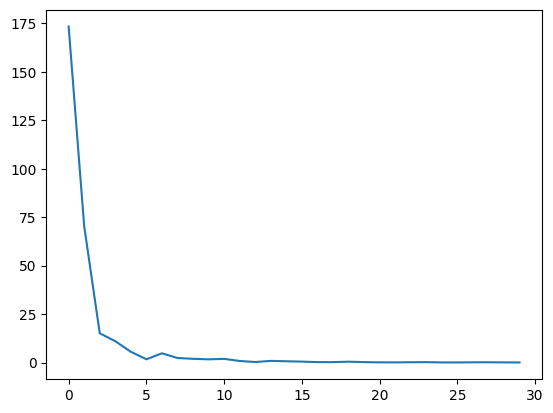

In [20]:
import matplotlib.pyplot as plt

loss = []
for i in range(30):
    loss.append(agent.learn_experience_replay(debug=False))

plt.plot(loss)
plt.show()

Let's now see the second function Q_learning, where we are going to play multiple games, collect the samples for our training after each move and actually train our model.

In [21]:
import time
import pandas as pd

def Q_learning(agent, stockfish, games_to_play, max_game_moves, board_config=None):

    loss = []
    final_score = []
    games = 0
    steps = 0
    start_time = time.time()

    # we play n games
    while games < games_to_play:

        games += 1

        # Create a new standard board
        if board_config is None:
            board = chess.Board()
        
        # Create a board with the desired configuration (pieces and starting positions)
        else:
            board = chess.Board(board_config)

        done = False
        game_moves = 0

        # analyse board with stockfish
        analysis = stockfish.analyse(board=board, limit=chess.engine.Limit(depth=5))
        
        # get best possible move according to stockfish (with depth=5)
        best_move = analysis['pv'][0]

        # until game is not finished
        while not done:

            game_moves += 1
            steps += 1

            # choose action, here the agent choose whether to explore or exploit
            action_index, move, bit_state, valid_move_tensor = agent.select_action(board, best_move)

            # save this score to compute the reward after the opponent move
            board_score_before = analysis['score'].relative.score(mate_score=10000) / 100

            # white moves
            board.push(move)

            # the game is finished (checkmate, stalemate, draw conditions, ...) or we reached max moves
            done = board.result() != '*' or game_moves > max_game_moves
            
            if done:
                
                final_result = board.result()
                
                # if the game is still not finished (meaning we reached max moves without ending the game) or draw
                # we assign a negative reward
                if final_result == '*' or final_result == "1/2-1/2":
                    reward = -10
                
                # if white wins
                elif final_result == "1-0":
                    reward = 1000
                
                # if black wins
                else:
                    reward = -1000

                # store sample in memory
                agent.remember(agent.MAX_PRIORITY, bit_state, action_index, reward, None, done, valid_move_tensor, None)
                
                board_score_after = reward
                
            # game not finished
            else:

                # black moves
                board.push(random.choice(list(board.legal_moves)))

                # board score is back to our perspective after black moves, so no need to change signs
                analysis = stockfish.analyse(board=board, limit=chess.engine.Limit(depth=5))
                board_score_after = analysis['score'].relative.score(mate_score=10000) / 100

                # is game finished?
                done = board.result() != '*'
                
                # if not done, update next best move
                if not done:
                    best_move = analysis['pv'][0]

                next_bit_state = agent.convert_state(board)
                next_valid_move_tensor, _ = agent.mask_and_valid_moves(board)
                
                # divide by 100 to convert from centipawns to pawns score
                reward = board_score_after - board_score_before - 0.01
                                
                # store sample in memory
                agent.remember(agent.MAX_PRIORITY, bit_state, action_index, reward, next_bit_state, done, valid_move_tensor, next_valid_move_tensor)
                                

            # train model and store loss
            loss.append(agent.learn_experience_replay(debug=False))

            # adjust epsilon (exploration rate)
            agent.adaptiveEGreedy()

        # save final game score
        final_score.append(board_score_after)

    # plot training results
    score_df = pd.DataFrame(final_score, columns=["score"])
    score_df['ma'] = score_df["score"].rolling(window = games // 5).mean()
    loss_df = pd.DataFrame(loss, columns=["loss"])
    loss_df['ma'] = loss_df["loss"].rolling(window=steps // 5).mean()

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Plot the score chart in the first subplot
    ax1.plot(score_df.index, score_df["score"], linewidth=0.2)
    ax1.plot(score_df.index, score_df["ma"])
    ax1.set_title('Final score by game')

    # Plot the loss chart in the second subplot
    ax2.plot(loss_df.index, loss_df["loss"], linewidth=0.1)
    ax2.plot(loss_df.index, loss_df["ma"])
    ax2.set_title('Loss by training step')

    # Show the plot
    plt.show()

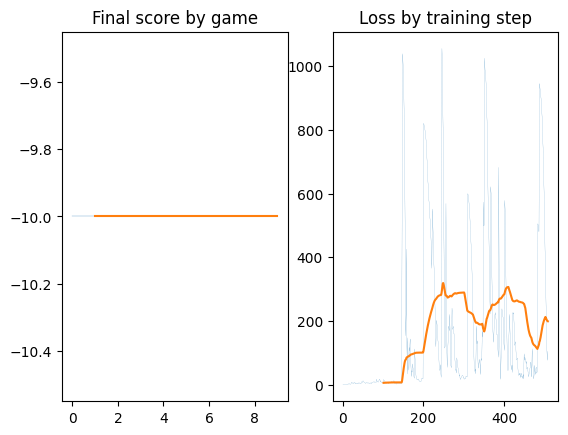

In [22]:
Q_learning(agent, stockfish, games_to_play=10, max_game_moves=50)

The loss gradually decrease as the samples with greater loss have a greater chance of being extracted for the training.

## Test the agent
To test the model we are going to make it play a series of games against a random agent and see the % of games it manages to win.

Of course we would expect any good agent to win 100% of games against a player who chooses random move all the time, but given the huge number of possible states and actions it is not so trivial without extensive training.

Just training on our local machines and without spending too much training time, we just want to see that a trained model performs better than a non-trained model (which we expect to win around 50% of time, because it will choose random moves as well)

In [23]:
def choose_move(agent, board):
    
    if agent == 'random':
        chosen_move = random.choice(list(board.legal_moves))
    
    else:
        bit_state = agent.convert_state(board)
        valid_moves_tensor, valid_move_dict = agent.mask_and_valid_moves(board)

        with torch.no_grad():
            tensor = torch.from_numpy(bit_state).float().unsqueeze(0)
            policy_values = agent.policy_net(tensor, valid_moves_tensor)
            chosen_move_index = int(policy_values.max(1)[1].view(1, 1))
            
            if chosen_move_index not in valid_move_dict:
                chosen_move = random.choice(list(board.legal_moves))
            else:
                chosen_move = valid_move_dict[chosen_move_index]
                
    return chosen_move


def test(agent, games=1, board_config=None):

    outcomes = []
    for game in range(games):
        
        done = False
        
        # Create a new standard board
        if board_config is None:
            board = chess.Board()
        
        # Create a board with the desired configuration (pieces and starting positions)
        else:
            board = chess.Board(board_config)
        
        game_moves = 0
        while not done:
            game_moves += 1
            
            # white moves
            if game_moves % 2 != 0:
                board.push(choose_move(agent, board))
            
            # black moves
            else:
                board.push(choose_move("random", board))
                
            done = board.result(claim_draw=True) != '*'

        outcomes.append(board.result(claim_draw=True))

    outcome_dict = {"1-0":"White won", "1/2-1/2":"Draw", "0-1":"Black won"}
    for o in set(outcomes):
        print(f"{o} {outcome_dict[o]}: {round(outcomes.count(o)/len(outcomes)*100)}%")

In [24]:
# This is the agent we trained for just 10 games
test(agent, games=20)

0-1 Black won: 5%

1/2-1/2 Draw: 95%


The model learned very little with so little training, but let's load a model trained with 2000 games to see if we can notice any difference.

In [25]:
test(ChessAgent(input_model_path="pretrained-agent-2000"), games=20)

1-0 White won: 5%

1/2-1/2 Draw: 90%

0-1 Black won: 5%


Even with 2000 games, the results are pretty much random.

This is because there are so many chess states and actions that the model should probably be trained on hundreds of thousands of games, which is beyond our goal here.

However, let's see how the model can learn really fast on simplified board positions.

### Mate in 1

In [26]:
mate_in_1_board = "k7/8/1K6/8/8/4R3/8/8"

board = chess.Board(mate_in_1_board)
print(board.unicode())

♚ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘

⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘

⭘ ♔ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘

⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘

⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘

⭘ ⭘ ⭘ ⭘ ♖ ⭘ ⭘ ⭘

⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘

⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘


In [27]:
# Create an agent
agent = ChessAgent()

# Create a stockfish engine instance
stockfish = chess.engine.SimpleEngine.popen_uci("../stockfish-windows-2022-x86-64-avx2")

In [28]:
# no training
test(agent, games=10, board_config=mate_in_1_board)

1/2-1/2 Draw: 100%


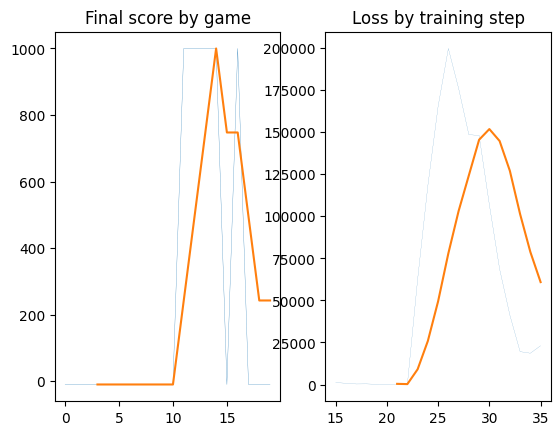

In [29]:
Q_learning(agent, stockfish, games_to_play=20, max_game_moves=1, board_config=mate_in_1_board)

In [30]:
# 20 games training
test(agent, games=10, board_config=mate_in_1_board)

1-0 White won: 100%


### Mate in 2

In [31]:
mate_in_2_board = "k7/8/8/K7/8/4R3/8/8"

board = chess.Board(mate_in_2_board)
print(board.unicode())

♚ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘

⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘

⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘

♔ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘

⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘

⭘ ⭘ ⭘ ⭘ ♖ ⭘ ⭘ ⭘

⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘

⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘


In [32]:
test(agent, games=10, board_config=mate_in_2_board)

1/2-1/2 Draw: 100%


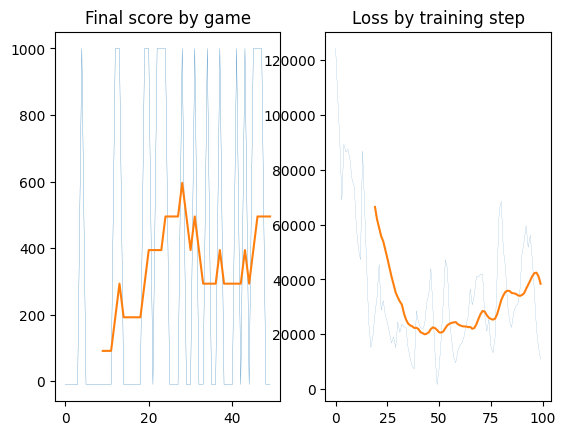

In [33]:
Q_learning(agent, stockfish, games_to_play=50, max_game_moves=1, board_config=mate_in_2_board)

In [34]:
#20 games training (mate in 1) + 50 games training (mate in 2)
test(agent, games=10, board_config=mate_in_2_board)

1-0 White won: 100%


## Conclusion and Next Steps
We have built 2 chess agent with 2 different strategies (minimax and reinforcement learning).

Of course at this stage they are not ready to compete against any serious state-of-the-art engine, but they are a good start to continue experimenting.

Like for our minimax model, here are some possible next steps for optimization:
- Optimize the number of nodes in the output layer of the neural network (not every one of the 4096 theoretical moves is actually possible, for example no piece can move from a1 to b7)
- Test and optimize neural net hyperparameters (number of layers, type of layers, number of nodes per layer, activation functions, ...)
- Test and optimize learning parameters (gamma, epsilon, batch_size, memory_size, ...)
- Train for a MUCH greater number of steps (move the code to AWS to train the model on a cluster of GPU-optimized machines). It is very easy to run the code on GPU (https://pytorch.org/get-started/locally/)
- Train the model using curriculum learning. Train on increasingly complex positions instead of starting with the full board from the beginning (like we show in the mate in 1 and mate in 2 examples)
- Generate more training samples with self-play (making the engine play as both white and black)
- Include opening book and endgame tables to reduce drastically the number of states where we need to use the engine